# Hodiny 16-17 — Labyrint a AI (Sešit)

Sešit obsahuje: modelování bludiště, implementace BFS/DFS, vizualizaci, A* a Pygame projekt.

## 1) Importy a nastavení

Níže importujeme základní knihovny, nastavíme semeno a jednoduchý logger. Pokud běžíte v Google Colab, nainstalujte `pygame` pokud chcete interaktivní ukázku (Colab to nativně nepodporuje, ale lze použít lokálně).

Recommended minimal requirements (put in `requirements.txt` if needed):
```
numpy
matplotlib
pygame
pytest
```


In [1]:
# Section 1: Importy a nastavení
import random
import time
import logging
from collections import deque
import heapq
import numpy as np
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger('maze')

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
print('Imports ready, seed set to', SEED)

Imports ready, seed set to 42


Sekce 1 — Importy a nastavení (učební text)

Tato část připravuje prostředí pro práci s bludišti a algoritmy. Používané knihovny mají následující role:
- `numpy` — efektivní práce s maticemi (reprezentace bludiště jako 2D pole).
- `matplotlib` — vizualizace bludišť a cest.
- `collections.deque` — efektivní fronta pro BFS.
- `heapq` — prioritní fronta, kterou použijeme v A*.
- `logging` — jednoduché logování pro ladění a měření.

Praktický tip: vždy nastavte semeno (`seed`) pro opakovatelné výsledky při generování bludišť a testech. V produkci necháte semeno náhodné, v učebních příkladech ho fixujte, aby studenti dostali stejné výstupy.

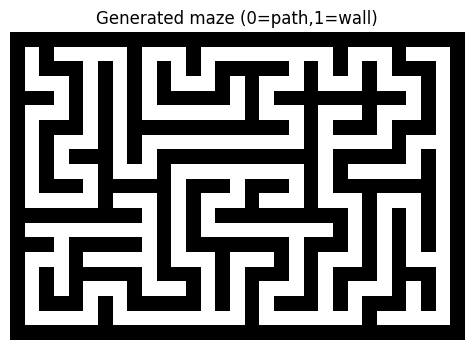

In [11]:
# Section 2: Modelování bludiště — reprezentace a převod na stavový prostor

def make_empty_grid(rows, cols):
    return np.ones((rows, cols), dtype=np.int8)  # 1 = wall, 0 = free


def carve_maze_recursive_backtracker(rows, cols):
    # Generate perfect maze on grid cells (cells represent passages on odd indices)
    grid = np.ones((rows, cols), dtype=np.int8)
    start = (1,1)
    grid[start] = 0
    stack = [start]
    dirs = [(2,0),(-2,0),(0,2),(0,-2)]
    while stack:
        r,c = stack[-1]
        neighbors = []
        for dr,dc in dirs:
            nr, nc = r+dr, c+dc
            if 1 <= nr < rows-1 and 1 <= nc < cols-1 and grid[nr,nc] == 1:
                neighbors.append((nr,nc))
        if neighbors:
            nr,nc = random.choice(neighbors)
            # remove wall between
            grid[(r+nr)//2, (c+nc)//2] = 0
            grid[nr,nc] = 0
            stack.append((nr,nc))
        else:
            stack.pop()
    return grid


def is_walkable(grid, pos):
    r,c = pos
    rows,cols = grid.shape
    if 0 <= r < rows and 0 <= c < cols:
        return grid[r,c] == 0
    return False


def neighbors(grid, pos):
    r,c = pos
    for dr,dc in [(1,0),(-1,0),(0,1),(0,-1)]:
        nr, nc = r+dr, c+dc
        if is_walkable(grid, (nr,nc)):
            yield (nr,nc)


def pos_to_index(pos, cols):
    r,c = pos
    return r*cols + c


def index_to_pos(idx, cols):
    return (idx // cols, idx % cols)

# quick demo
rows,cols = 21,31
maze = carve_maze_recursive_backtracker(rows, cols)
plt.figure(figsize=(6,4))
plt.imshow(maze, cmap='gray_r')
plt.title('Generated maze (0=path,1=wall)')
plt.axis('off')
plt.show()

Sekce 2 — Modelování bludiště (učební text)

Cílem této části je ukázat, jak převést reálné bludiště na vhodný formát pro algoritmy hledání.

Hlavní krok: reprezentace
- Používáme mřížku (2D pole), kde každá buňka má stav (zeď / průchozí).
- Stavy se dají převést na uzly grafu: každý průchozí bod je uzel, hrany jsou sousední průchody.

Generování bludiště (recursive backtracker)
- Generátor začíná v jednom bodě a náhodně vyhlubuje cesty, dokud není celé bludiště vytvořeno.
- Výsledek: tzv. "perfect maze" (bez smyček), což je užitečné pro demonstraci hledacích algoritmů.

Doporučení ke cvičení: studenti si vyzkouší měnit rozměry mřížky a pozorovat, jak se mění struktura bludiště.

In [12]:
# Section 3: Implementace algoritmů — BFS a DFS

def bfs(grid, start, goal):
    queue = deque([start])
    parent = {start: None}
    while queue:
        current = queue.popleft()
        if current == goal:
            path = []
            node = current
            while node is not None:
                path.append(node)
                node = parent[node]
            return list(reversed(path)), parent
        for n in neighbors(grid, current):
            if n not in parent:
                parent[n] = current
                queue.append(n)
    return None, parent


def dfs(grid, start, goal):
    stack = [start]
    parent = {start: None}
    while stack:
        current = stack.pop()
        if current == goal:
            path = []
            node = current
            while node is not None:
                path.append(node)
                node = parent[node]
            return list(reversed(path)), parent
        for n in neighbors(grid, current):
            if n not in parent:
                parent[n] = current
                stack.append(n)
    return None, parent

# step generator for visualization (yields current node and frontier)
def bfs_steps(grid, start):
    queue = deque([start])
    parent = {start: None}
    while queue:
        current = queue.popleft()
        yield current, list(queue), dict(parent)
        for n in neighbors(grid, current):
            if n not in parent:
                parent[n] = current
                queue.append(n)

# small unit tests on a trivial maze
small = np.array([
    [1,1,1,1,1],
    [1,0,0,0,1],
    [1,0,1,0,1],
    [1,0,0,0,1],
    [1,1,1,1,1],
])
start = (1,1)
goal = (3,3)
path_bfs, _ = bfs(small, start, goal)
path_dfs, _ = dfs(small, start, goal)
print('BFS path length', len(path_bfs)-1)
print('DFS path length', len(path_dfs)-1)
assert path_bfs is not None and path_dfs is not None
# BFS should find a shortest path in unweighted grid
assert len(path_bfs)-1 <= len(path_dfs)-1
print('BFS/DFS tests passed')

BFS path length 4
DFS path length 4
BFS/DFS tests passed


Sekce 3 — BFS a DFS (učební text)

BFS (Breadth‑First Search)
- BFS zkoumá uzly po úrovních: nejdřív všechny uzly vzdálené 1 krok, pak 2 kroky atd.
- Garantuje nejkratší počet kroků v neohodnocené mřížce.

DFS (Depth‑First Search)
- DFS jde vždy co nejhlouběji, vrací se zpět, když narazí na slepou uličku.
- Není zaručeno, že najde nejkratší cestu, ale často je jednoduché ji implementovat a využít pro backtracking (najít řešení bez ohledu na délku).

Step‑generator
- Pro pedagogické účely poskytujeme generátor kroků, který umožní vizualizovat postup algoritmů (fronta/stack, aktuální uzel).

BFS found 130 steps


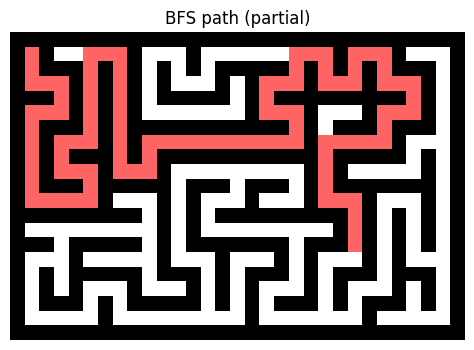

In [13]:
# Section 4: Vizualizace průchodu a krokování algoritmů

def draw_maze(grid, path=None, visited=None, title=None):
    img = np.zeros(grid.shape + (3,), dtype=np.uint8)
    # walls = black, free = white
    img[grid==1] = (0,0,0)
    img[grid==0] = (255,255,255)
    if visited:
        for (r,c) in visited:
            img[r,c] = (200,200,255)
    if path:
        for (r,c) in path:
            img[r,c] = (255,100,100)
    plt.figure(figsize=(6,4))
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# quick demo using previously generated maze and BFS
start = (1,1)
goal = (rows-2, cols-2)
path_bfs, parent = bfs(maze, start, goal)
print('BFS found', 0 if path_bfs is None else len(path_bfs)-1, 'steps')
# show a snippet
draw_maze(maze, path=path_bfs[:100] if path_bfs else None, title='BFS path (partial)')

Sekce 4 — Vizualizace průchodu a krokování (učební text)

Proč vizualizovat:
- Lidskému mozku pomáhá vidět, jak algoritmus prohledává prostor. Můžeme odlišit navštívené uzly, frontu/stack a finální cestu.

Co zobrazení ukazuje:
- Barvy: stěny, průchodné buňky, navštívené body, konečná cesta.
- Krokování (step‑viz): animace nebo série obrázků pomáhá studentům pochopit dynamiku algoritmu.

Praktická rada: při tvorbě animací ukládejte snímky a spojujte je do GIF (matplotlib + imageio) nebo použijte Pygame pro živou vizualizaci.

In [14]:
# Section 5: Optimalizace — heuristiky a A*

def manhattan(a,b):
    return abs(a[0]-b[0]) + abs(a[1]-b[1])


def euclidean(a,b):
    return ((a[0]-b[0])**2 + (a[1]-b[1])**2)**0.5


def astar(grid, start, goal, heuristic_fn=manhattan):
    open_set = []
    heapq.heappush(open_set, (heuristic_fn(start,goal), 0, start, None))
    came_from = {}
    g_score = {start: 0}
    expanded = 0
    while open_set:
        f,g,current,parent = heapq.heappop(open_set)
        if current in came_from:
            continue
        came_from[current] = parent
        expanded += 1
        if current == goal:
            path = []
            node = current
            while node is not None:
                path.append(node)
                node = came_from[node]
            return list(reversed(path)), expanded
        for n in neighbors(grid, current):
            tentative_g = g + 1
            if n in g_score and tentative_g >= g_score[n]:
                continue
            g_score[n] = tentative_g
            heapq.heappush(open_set, (tentative_g + heuristic_fn(n,goal), tentative_g, n, current))
    return None, expanded

# compare BFS, DFS, A* on the generated maze
start = (1,1)
goal = (rows-2, cols-2)
start_time = time.time(); p_bfs, _ = bfs(maze, start, goal); t_bfs = time.time() - start_time
start_time = time.time(); p_dfs, _ = dfs(maze, start, goal); t_dfs = time.time() - start_time
start_time = time.time(); p_astar, exp_astar = astar(maze, start, goal, manhattan); t_astar = time.time() - start_time
print(f'BFS: steps={(0 if p_bfs is None else len(p_bfs)-1):d}, time={t_bfs:.4f}s')
print(f'DFS: steps={(0 if p_dfs is None else len(p_dfs)-1):d}, time={t_dfs:.4f}s')
print(f'A*: steps={(0 if p_astar is None else len(p_astar)-1):d}, expanded={exp_astar}, time={t_astar:.4f}s')
assert p_astar is not None, 'A* failed to find path'
# A* should be at least as good as BFS in steps for admissible heuristic in perfect maze
if p_bfs is not None:
    assert len(p_astar)-1 <= len(p_bfs)-1
print('A* test passed')

BFS: steps=130, time=0.0002s
DFS: steps=130, time=0.0003s
A*: steps=130, expanded=173, time=0.0002s
A* test passed


Sekce 5 — Heuristiky a A* (učební text)

Co je heuristika:
- Heuristika je odhad zbývající vzdálenosti k cíli. Pokud tento odhad nikdy nepřecení skutečnou vzdálenost, heuristika je admisibilní a A* najde nejkratší cestu.

Jak A* funguje (ELI10):
- A* udržuje prioritu podle f = g + h, kde g je skutečný náklad z počátku a h je heuristický odhad.
- Díky tomu A* kombinuje výhody Dijkstry (správné náklady) a heuristiky (rychlost hledání směrem k cíli).

Praktické tipy:
- Manhattanova heuristika je vhodná pro mřížky s povoleným pohybem jen v 4 směrech.
- Euclidean používáme, když povolíme diagonály; v takovém případě nastavíme správné náklady pro diagonální krok.

## 6) Projekt: Bludiště v Pygame — generátor, vykreslení, interaktivní řešič

Níže je jednoduchý projektový nástin (scaffold). Colab většinou nepodporuje interaktivní Pygame okna — spusť lokálně v Pythonu (např. `python main.py`).

Struktura projektu:
- `maze_game/`
  - `main.py`  # spuštění hry
  - `maze.py`  # generátor a pomocné funkce
  - `ai.py`    # BFS/DFS/A* řešič
  - `requirements.txt`

Ukázka `main.py` (zkráceně):
```python
# ...existing code...
import pygame
from maze import carve_maze_recursive_backtracker
from ai import astar

# initialize pygame, draw grid, handle key events, button to run AI
```

Doporučení: Nechte studenty implementovat krokování AI (jeden krok na frame) a vizualizovat frontu.

## 7) Jednotkové testy a měření výkonu

Doporučené testy (pytest):
- generátor vytváří průchozí start i cíl
- neighbors() vrací korektní sousedy
- BFS vrací nejkratší cestu na jednoduchém gridu

Měření výkonu: použijte `timeit` nebo `cProfile` pro porovnání počtu rozšířených uzlů a času mezi BFS, DFS a A*.

Úkoly pro studenty:
1. Implementujte v `ai.py` krokování a tlačítko "krok" v Pygame.
2. Přidejte diag. pohyb a porovnejte výsledky.
3. Vytvořte benchmark skript, který spustí 10 map s různou hustotou zdí a porovná průměrné časy a průměrné délky cest.
4. Přepište generátor pomocí Primova algoritmu a porovnejte tvar bludiště a složitost řešení.

Hotovo: Sešit uložen jako `/Users/martinsvanda/Praut/Odoo/Bez názvu/AI_Zaklady_Hodiny_16_17.ipynb`.

Vysvětlení (ELI10) k jednotlivým sekcím

Sekce 1 — Importy a nastavení
- Co děláme: Načteme knihovny a nastavíme semeno a logger. To zajistí reprodukovatelnost a jednoduché ladění.
- Proč to potřebujeme: Knihovny jako NumPy a Matplotlib nám umožní pracovat s políčky a kreslit bludiště; `heapq` a `collections` používáme pro priority frontu a frontu/stacky v algoritmech.

Sekce 2 — Modelování bludiště: reprezentace a převod na stavový prostor
- Co děláme: Bludiště reprezentujeme jako 2D pole (matice) kde 1 = zeď, 0 = průchozí buňka. Generátor (recursive backtracker) vytvoří perfektní bludiště bez cyklů.
- Proč to děláme: Převod na mřížku nám umožní snadno definovat stavy (souřadnice buněk) a operátory (pohyb na sousední buňku). Funkce `is_walkable` a `neighbors` poskytují jednotné API pro všechny algoritmy.

Sekce 3 — Implementace algoritmů: BFS a DFS
- Co děláme: Implementujeme BFS (šířkové prohledávání) a DFS (hloubkové) tak, aby vracely cestu a mapu rodičů. Přidali jsme i step‑generator pro vizualizaci průběhu.
- Jak to funguje (ELI10): BFS prohledává vrstvu po vrstvě a proto najde nejkratší cestu v neohodnocené mřížce. DFS jde co nejhlouběji a může najít cestu rychle, ale nemusí být nejkratší.

Sekce 4 — Vizualizace průchodu a krokování algoritmů
- Co děláme: Kreslíme mřížku s barvami pro zdi, navštívené buňky a finální cestu. Funkce `draw_maze` umožní rychlou kontrolu a obrázek pro výuku.
- Proč to pomáhá: Interaktivní nebo kroková vizualizace dělá algoritmus pochopitelnějším — vidíte frontu/stack a jak se rozšiřují uzly.

Sekce 5 — Optimalizace: heuristiky a A*
- Co děláme: Přidali jsme heuristiky (Manhattan, Euclid) a implementaci A*, která kombinuje skutečný náklad g a odhad h.
- Důležitá poznámka (ELI10): Pokud heuristika nikdy nepřecení skutečnou vzdálenost (nazýváme to admisibilní), A* najde nejkratší cestu. Manhattan se hodí pro mřížky s 4 směry pohybu.

Sekce 6 — Projekt: Bludiště v Pygame
- Co děláme: Dáváme scaffold s `main.py`, `maze.py`, `ai.py`. Pygame použijeme pro interaktivní vizualizaci, ovládání hráče a krokování AI.
- Jak spustit: Spusťte lokálně (Colab obvykle Pygame okno nezobrazí). Doporučení: implementujte tlačítko "Krok" pro AI (jeden krok na frame), aby studenti mohli vidět postup algoritmu v reálném čase.

Sekce 7 — Jednotkové testy a měření výkonu
- Co děláme: Doporučujeme pytest testy pro generátor, funkce sousedů a základní scénáře pro BFS/DFS/A*. Dále měření (timeit, cProfile) pro srovnání počtu rozšířených uzlů a času.
- Proč: Testy zajišťují, že změny v generátoru nebo algoritmech nezpůsobí regress; benchmark ukáže, kdy je třeba optimalizovat datové struktury.

Krátké tipy pro studenty
- Začněte s malými mapami (5x5) a ověřte chování algoritmů.
- Vizualizujte průběh, nejen finální cestu — to pomáhá pochopit rozdíly mezi BFS/DFS/A*.
- Při implementaci Pygame udržujte hlavní smyčku jednoduchou a delegujte logiku do `ai.py`.

Pokud chceš, mohu teď:
- 1) Vložit tyto vysvětlující texty přímo do jednotlivých míst v sešitu (po každé sekci). Nebo
- 2) Nechat je jako celkové vysvětlení na konci (jak jsem právě udělal) a pokračovat dalším sešitem.
Napiš, kterou variantu preferuješ.